### Необходимык библиотеки

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20, 12)})

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Colab Notebooks/Диплом
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Диплом
 NPS_embed.ipynb   preprocess_news.xlsx     комментарии_банки.xlsx
 NSews_emb.ipynb   preprocess_recall.xlsx  'Новости коммераснат.xlsx'


### Подготавливаем данные

In [ ]:
comments_raw_data = pd.read_excel('Новости коммераснат.xlsx')

comments_raw_data['datetime'] = pd.to_datetime(comments_raw_data['datetime'], format='%d.%m.%Y, %H:%M')
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])

### Cтатистики

In [ ]:
min_ = comments_raw_data["datetime"].min().date()
max_ = comments_raw_data["datetime"].max().date()
print(f'min: {min_} \nmax: {max_}')

min: 2020-01-09 
max: 2023-12-01


In [ ]:
bank_counts = np.unique(comments_raw_data['bank'], return_counts=True)
popularity = sorted(list(zip(bank_counts[0], bank_counts[1])), key=lambda x:x[1], reverse=True)

In [ ]:
top_pop = -1
bank_set_ = popularity[:top_pop] #возьмем первык n банков
bank_set = [x[0] for x in bank_set_]

Text(0.5, 1.0, 'Кол-во статей с упоминаний c 2020-01-09 по 2023-12-01')

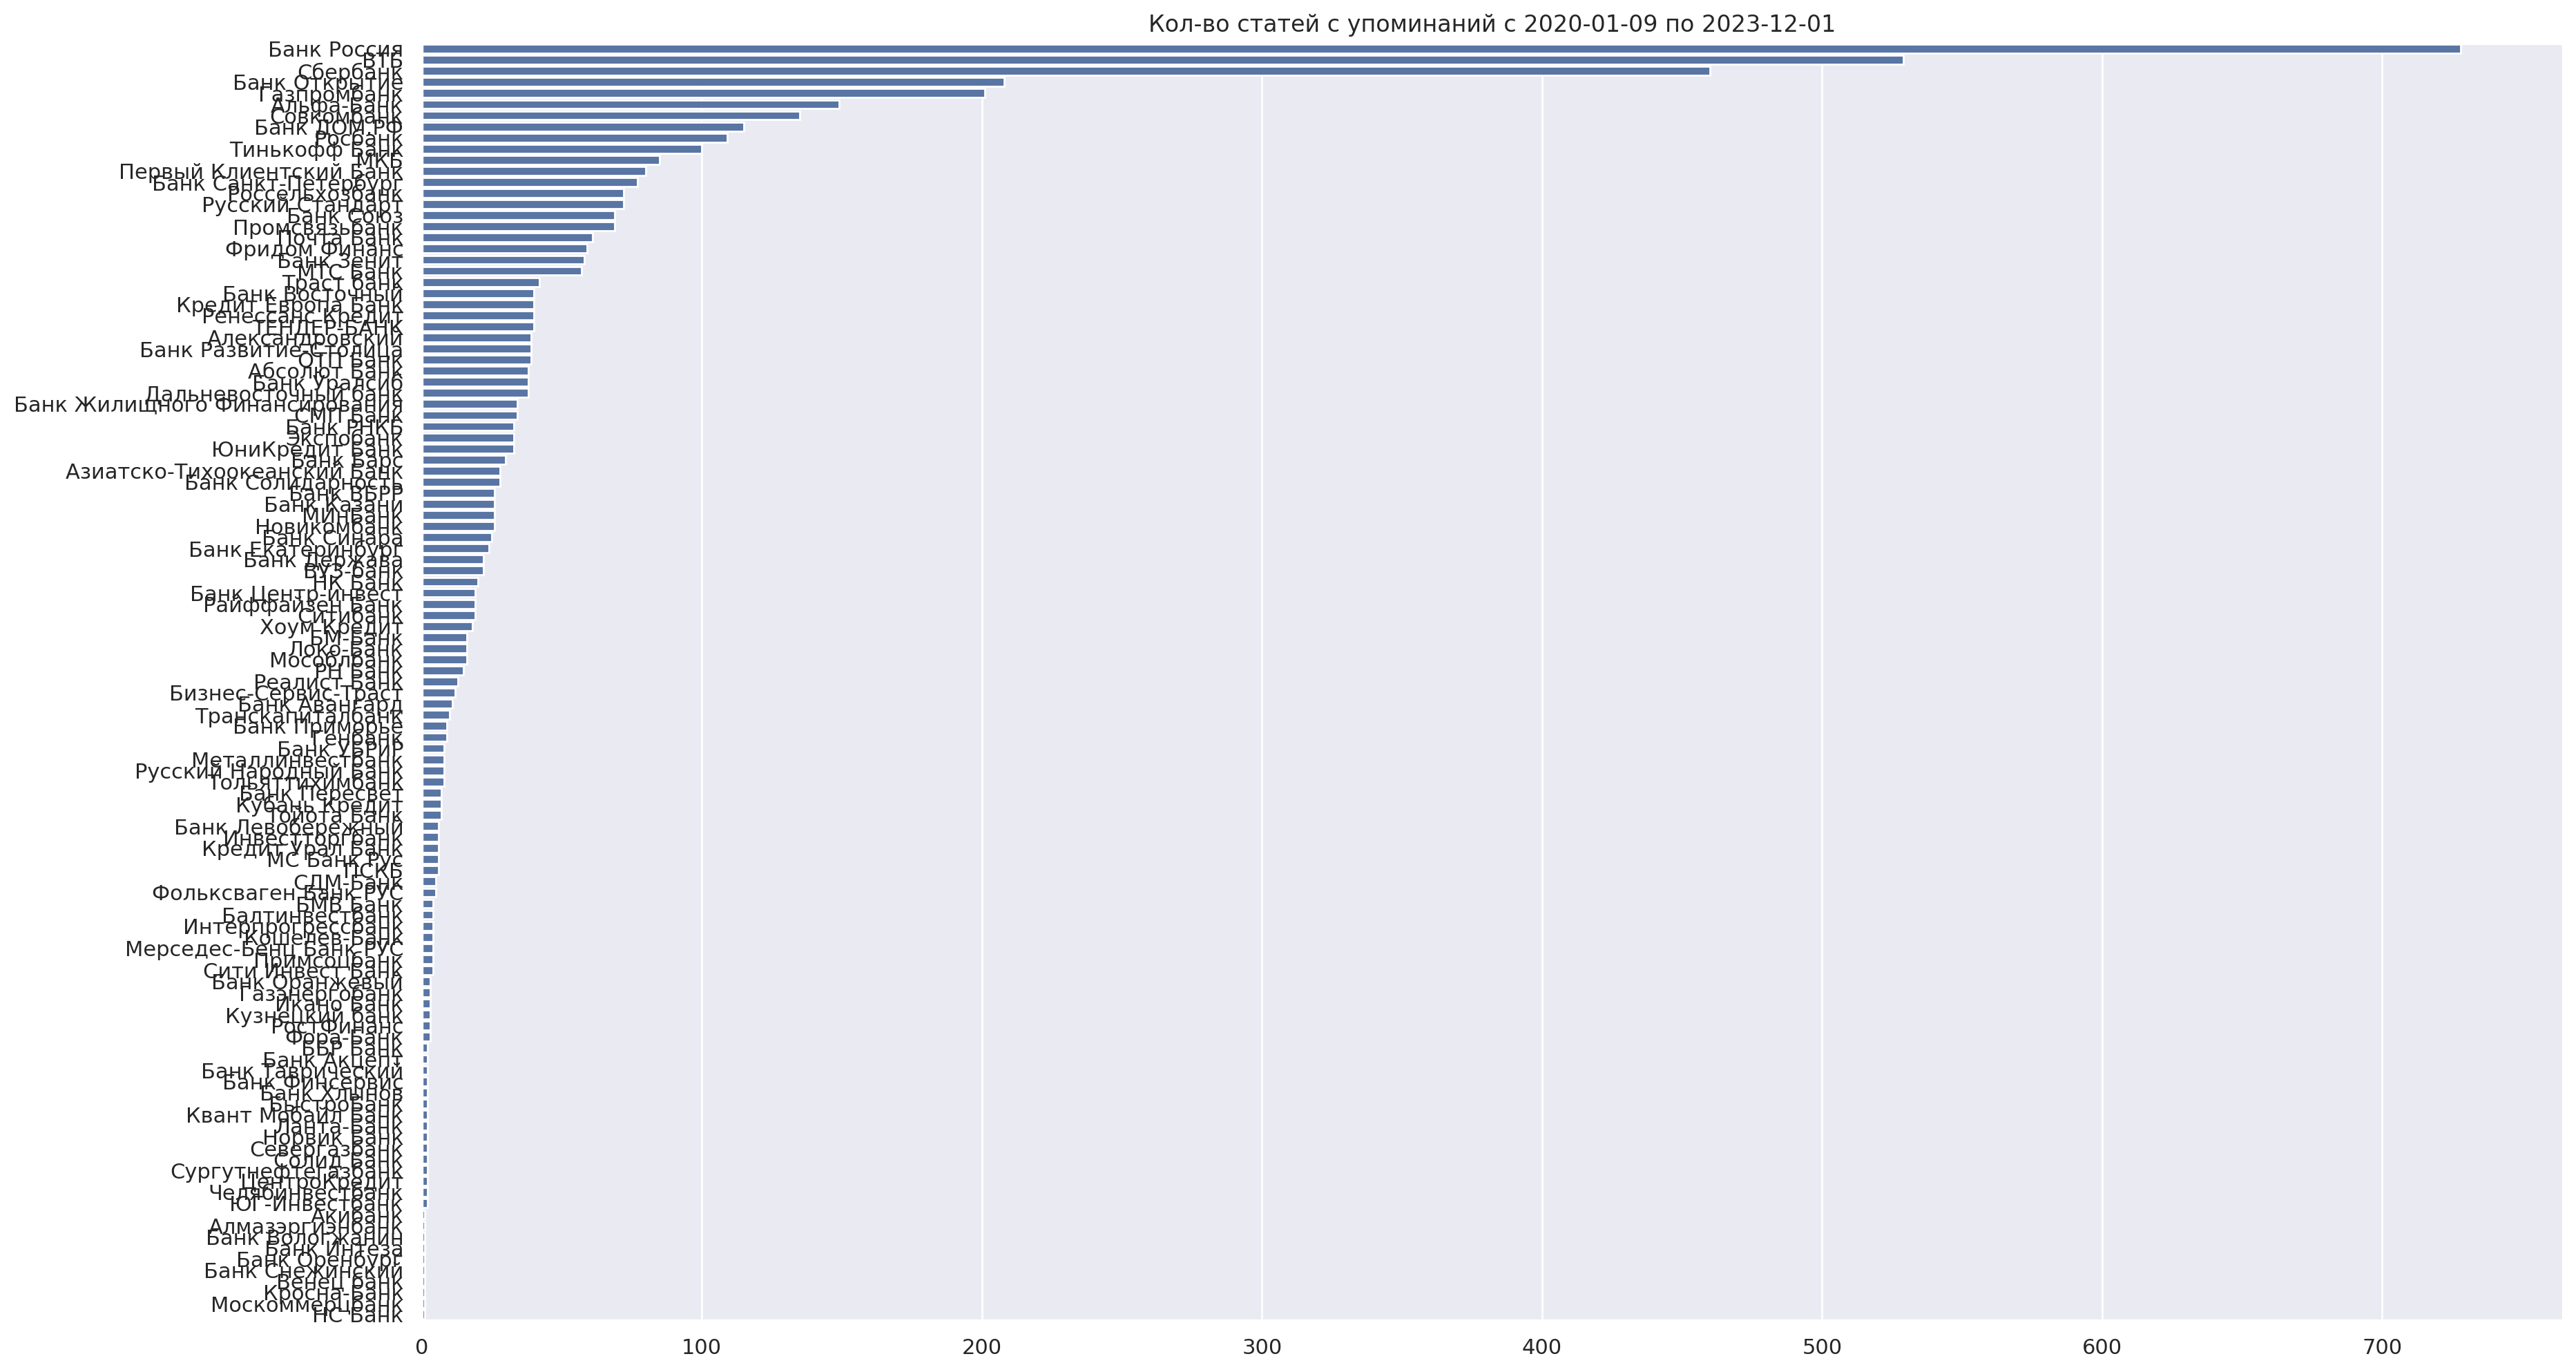

In [ ]:
names = [x[0] for x in bank_set_]
counts = [x[1] for x in bank_set_]

sns.barplot(x=counts, y=names).set_title(f'Кол-во статей с упоминаний c {min_} по {max_}')

In [ ]:
from wordcloud import WordCloud

In [ ]:
def draw_cloud(data):
    wc = WordCloud(background_color='white', max_words=1000,
                   width=1000, height=500)
    texts = data.astype(str)
    joint_text = ' '.join(list(texts))
    wc.generate(joint_text)
    return wc.to_image()

### Обработка текстов

In [ ]:
# data = comments_raw_data[comments_raw_data['bank'].isin(names)][['bank', 'paper_text']]
# data.to_excel('preprocess_news.xlsx')

In [ ]:
data = pd.read_excel('preprocess_news.xlsx').drop(columns=['Unnamed: 0'])

In [ ]:
data = data.dropna()

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation


mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)
    return text

In [ ]:
pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=49b84df7df6de9c514fc3764765a272583029fe4363b6901a30123a21064c82a
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
data['paper_text'] = data['paper_text'].parallel_apply(lambda x: preprocess_text(str(x)))

In [ ]:
data

bank                                         paper_text
0           Сбербанк  выяснять   “  ъ  ”, «  роснефть  »   мочь осущ...
1           Сбербанк  1 декабрь президент россия владимир путин приб...
2           Сбербанк  стоимость российский нефть urals 1 декабрь обн...
4           Сбербанк  фон очередной снижение цена золото серебро кот...
5           Сбербанк  разрабатывать евросоюз новый правило обмен дан...
...              ...                                                ...
4772  Банк Восточный  словесный интервенция представитель финансовый...
4773  Банк Восточный  владелец камчатский рыбный завод   «  сокра  »...
4774  Банк Восточный  краснодарский компания   «  восточный актив  »...
4775  Банк Восточный  цб устанавливать китайский банк индивидуальный...
4776  Банк Восточный  жесткий американский санкция попадать пять рос...

[4488 rows x 2 columns]

### Получение embeddings

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3)
tfidf.fit(data['paper_text'])

In [ ]:
bank_vectors = pd.DataFrame(columns=[x for x in range(len(tfidf.vocabulary_))])
for bank in tqdm(np.unique(data['bank'])):
    sen = np.mean(tfidf.transform(data[data['bank'] == bank]['paper_text']), axis=0)
    vec = pd.DataFrame(sen)
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

In [ ]:
bank_vectors = bank_vectors.to_numpy()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(bank_vectors)

In [ ]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})

In [ ]:
clusster_data['kmeans_clusters'] = kmeans.labels_

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 0]

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 1]

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 2]

In [ ]:
data = data.merge(clusster_data, how='left', on='bank')

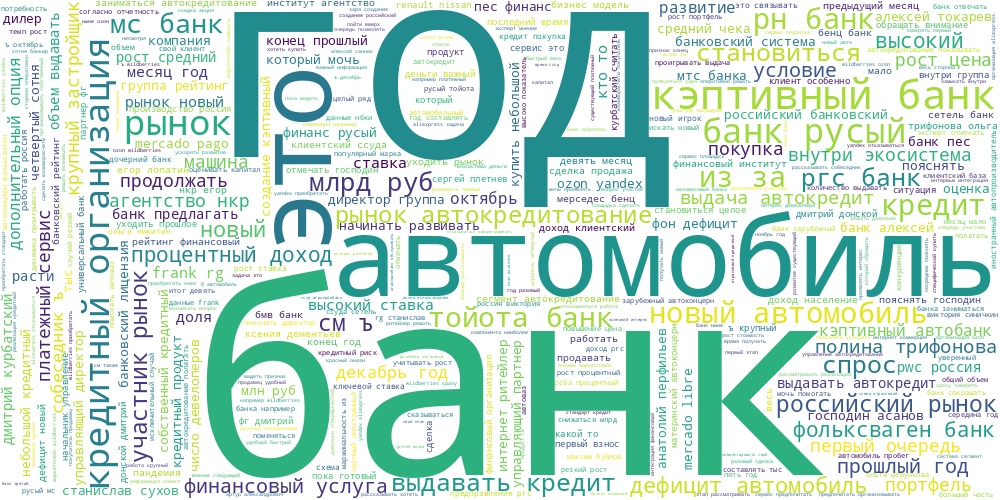

In [104]:
draw_cloud(data[data['kmeans_clusters'] == 1]['paper_text'])

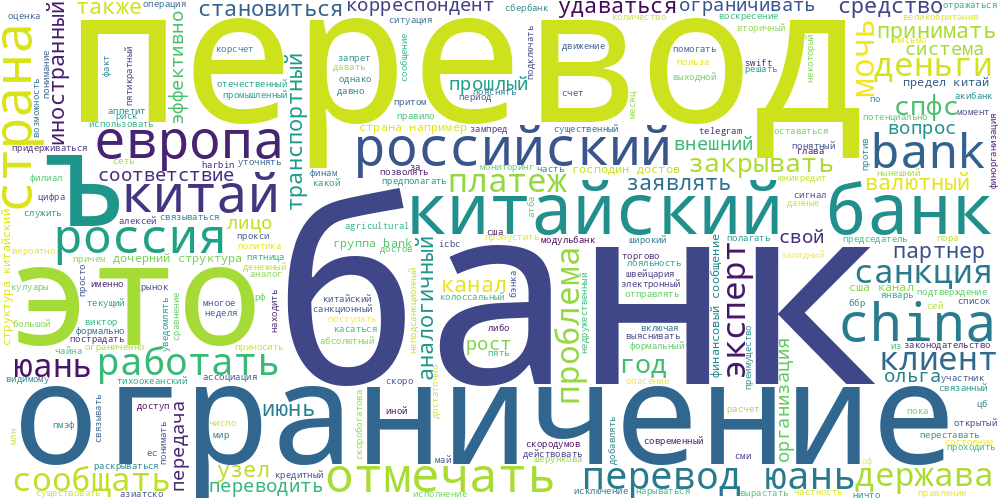

In [105]:
draw_cloud(data[data['kmeans_clusters'] == 0]['paper_text'])

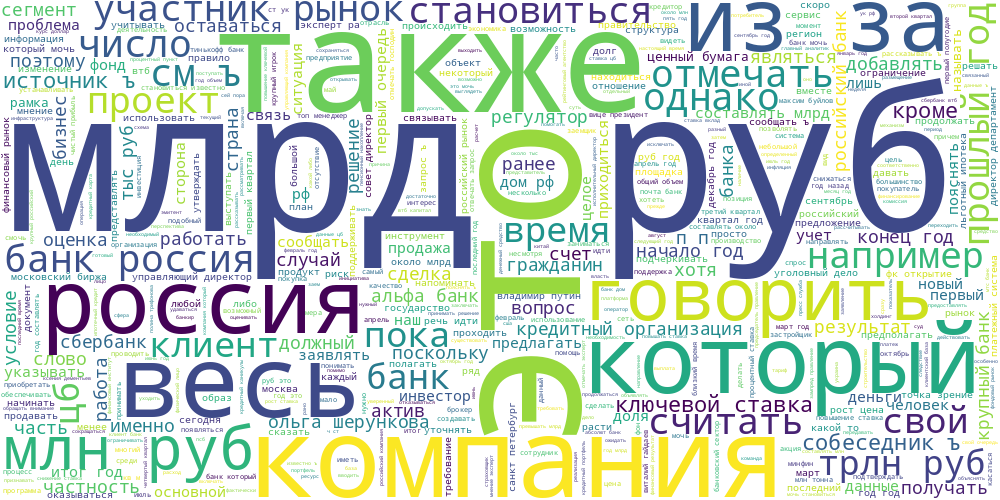

In [103]:
draw_cloud(data[data['kmeans_clusters'] == 2]['paper_text'])

### Embeddings

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [ ]:
def embed_bert_cls(text, model=model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
bank_vectors = pd.DataFrame(columns=[x for x in range(312)])
for bank in tqdm(np.unique(data['bank'])):
    bank_embeds = pd.DataFrame(columns=[x for x in range(312)])
    bank_text_data = data[data['bank'] == bank]['paper_text']
    for text in bank_text_data:
        bank_embeds = pd.concat([bank_embeds, pd.DataFrame(embed_bert_cls(text).reshape(1,-1))], axis=0)
    sen = np.mean(bank_embeds.to_numpy(), axis=0)
    vec = pd.DataFrame(sen.reshape(1,-1))
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

100%|██████████| 115/115 [00:44<00:00,  2.59it/s]


In [ ]:
data = pd.read_excel('preprocess_news.xlsx').drop(columns=['Unnamed: 0'])
data = data.dropna()

In [ ]:
from sklearn.cluster import SpectralClustering

spectr = SpectralClustering(n_clusters=6)
spectr.fit(bank_vectors)

SpectralClustering(n_clusters=6)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate='auto', init='random')
d2_feat = tsne.fit_transform(bank_vectors)

In [ ]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})
clusster_data['bert_clusters'] = spectr.labels_

In [ ]:
clusster_data['TSNE_0'] = d2_feat[:,0]
clusster_data['TSNE_1'] = d2_feat[:,1]

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 0]

bank  bert_clusters    TSNE_0    TSNE_1
11           Банк Акцепт              0  1.401690 -5.220343
14       Банк Вологжанин              0  0.413995  2.926778
43   Бизнес-Сервис-Траст              0  1.151304 -3.201362
44            БыстроБанк              0 -0.267989  2.970222
67              МТС Банк              0  0.191700 -3.311411
72               НК Банк              0  1.017697 -0.146623
73               НС Банк              0 -2.817428 -3.945076
79            Почта Банк              0 -0.917547  0.188276
99    Сургутнефтегазбанк              0 -0.283464 -4.024152
100          ТЕНДЕР-БАНК              0  1.055125 -2.954377
101        Тинькофф Банк              0 -1.346808  0.596067
111      Челябинвестбанк              0  0.753098 -3.994341

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 1]

bank  bert_clusters    TSNE_0    TSNE_1
0                   Абсолют Банк              1 -4.336334  0.116459
1    Азиатско-Тихоокеанский Банк              1 -3.158068  0.861966
5                     Альфа-Банк              1 -2.815648  0.453201
7                        БМ-Банк              1  0.576719  0.102050
9                 Балтинвестбанк              1 -6.534401  1.340011
..                           ...            ...       ...       ...
107                    Фора-Банк              1 -1.906216 -2.711195
108                Фридом Финанс              1 -3.327334 -1.350944
109                  Хоум Кредит              1 -4.047614  1.437709
112                    Экспобанк              1 -3.195894 -0.829443
114               ЮниКредит Банк              1 -4.745959  1.145120

[62 rows x 4 columns]

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 2]

bank  bert_clusters    TSNE_0    TSNE_1
2                   Акибанк              2 -1.504453 -4.047836
6                  ББР Банк              2  0.728542  1.775105
8                  БМВ Банк              2 -1.846395  4.053344
38               Банк УБРиР              2 -2.649803  2.566540
52               Икано Банк              2 -1.761837  3.972992
55        Квант Мобайл Банк              2 -5.751659  2.573676
68   Мерседес-Бенц Банк РУС              2 -1.766537  3.887508
77                     ПСКБ              2 -4.693855  2.197483
91                 СДМ-Банк              2 -4.155913  2.475408
96                 Ситибанк              2 -1.822236  2.467848
110            ЦентроКредит              2 -3.382682  3.238983

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 3]

bank  bert_clusters    TSNE_0    TSNE_1
21        Банк Интеза              3 -6.483603 -2.258068
34    Банк Снежинский              3 -4.991467 -2.903233
42  Банк Центр-инвест              3  0.523798 -2.309098
60      Кубань Кредит              3  2.086766 -0.903964
94       Севергазбанк              3 -6.451014 -2.160235
95   Сити Инвест Банк              3 -0.197789 -2.571763
98         Солид Банк              3 -2.883662 -2.493174

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 4]

bank  bert_clusters    TSNE_0    TSNE_1
3          Александровский              4  4.306963 -1.890324
10           Банк Авангард              4  3.750604 -1.956994
17            Банк Держава              4  3.335638 -1.549819
22             Банк Казани              4  2.433031 -2.002873
24          Банк Оранжевый              4  1.451997 -0.898975
25           Банк Оренбург              4  4.659775 -2.218820
28           Банк Приморье              4  2.852653 -2.246017
30   Банк Развитие-Столица              4  3.287508 -1.685536
35       Банк Солидарность              4  3.885074 -1.238157
40          Банк Финсервис              4  1.920309 -3.436841
41             Банк Хлынов              4  2.394660 -3.151924
46                ВУЗ-банк              4  2.040016 -2.439649
59             Кросна-Банк              4 -0.639770  1.480453
89   Русский Народный Банк              4  3.081862 -1.566964
90        Русский Стандарт              4  1.689679 -1.377470
113          ЮГ-Инвестбанк              4  3.156506 -3.626713

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 5]

bank  bert_clusters    TSNE_0    TSNE_1
4      Алмазэргиэнбанк              5  4.418010  0.262804
23   Банк Левобережный              5  2.791876  0.533519
47          Венец банк              5 -0.426224 -5.522973
54   Интерпрогрессбанк              5  2.557840  0.632252
70      Москоммерцбанк              5  4.116479  0.206876
75         Норвик Банк              5  2.330955  1.080832
103    Тольяттихимбанк              5  2.770480  0.680696

In [ ]:
data = data.merge(clusster_data, how='left', on='bank')

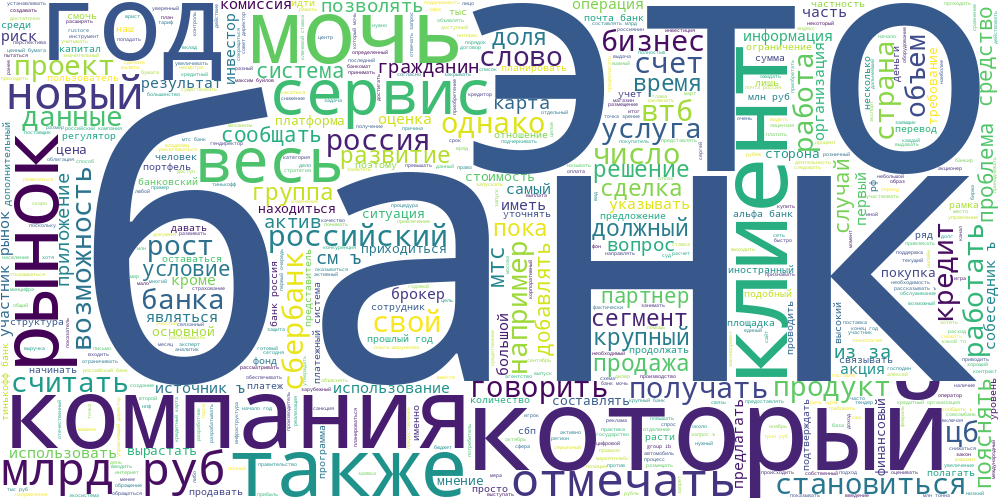

In [ ]:
draw_cloud(data[data['bert_clusters'] == 0]['paper_text'])

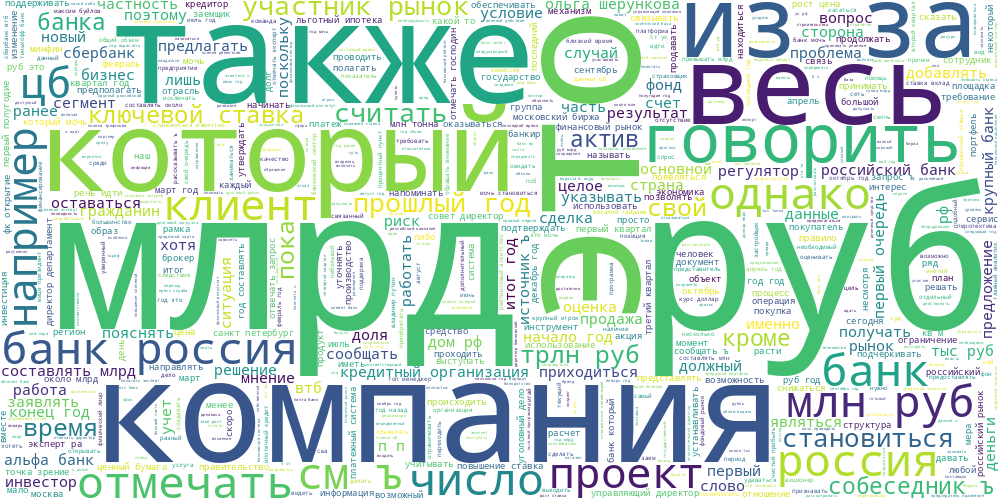

In [ ]:
draw_cloud(data[data['bert_clusters'] == 1]['paper_text'])

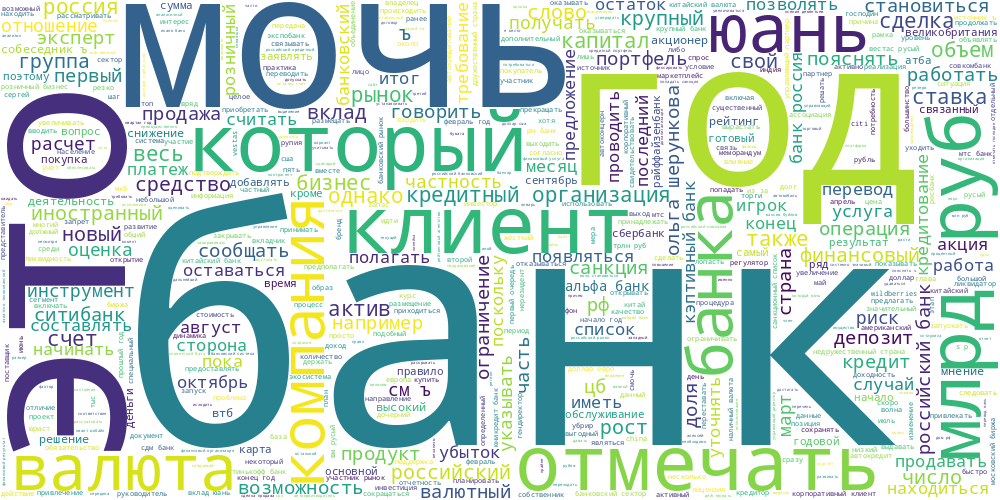

In [ ]:
draw_cloud(data[data['bert_clusters'] == 2]['paper_text'])

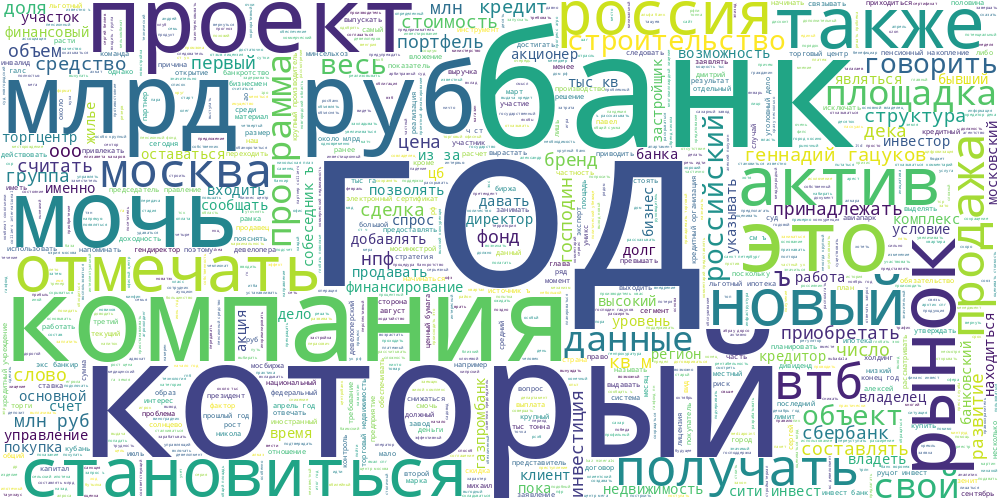

In [ ]:
draw_cloud(data[data['bert_clusters'] == 3]['paper_text'])

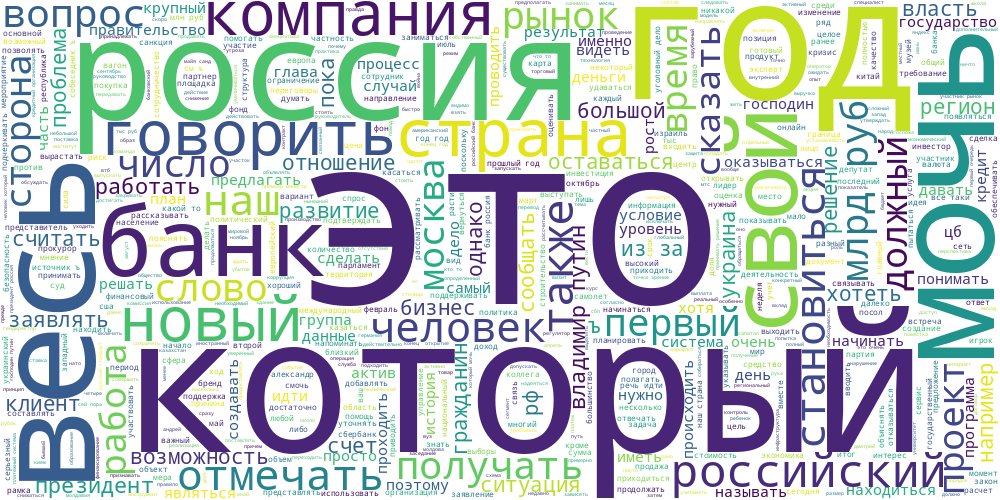

In [ ]:
draw_cloud(data[data['bert_clusters'] == 4]['paper_text'])

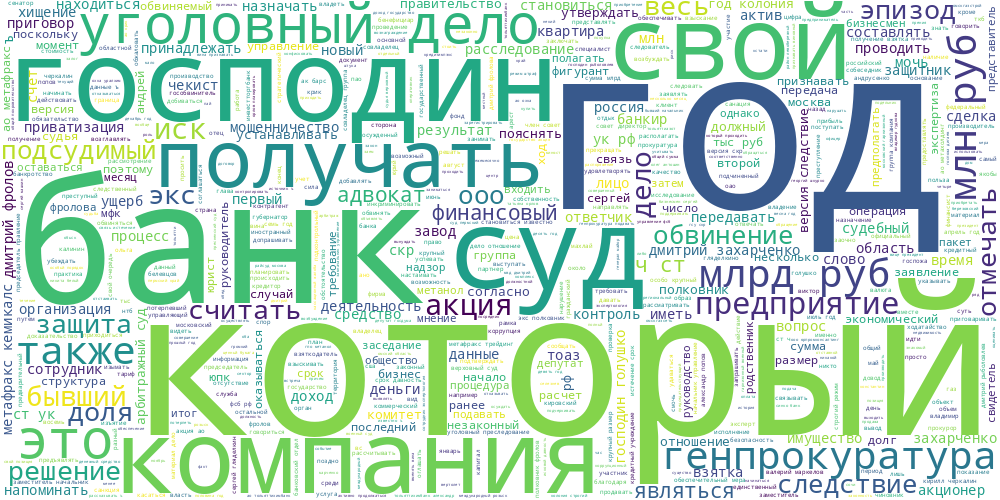

In [ ]:
draw_cloud(data[data['bert_clusters'] == 5]['paper_text'])

Text(0.5, 1.0, 'Spectr')

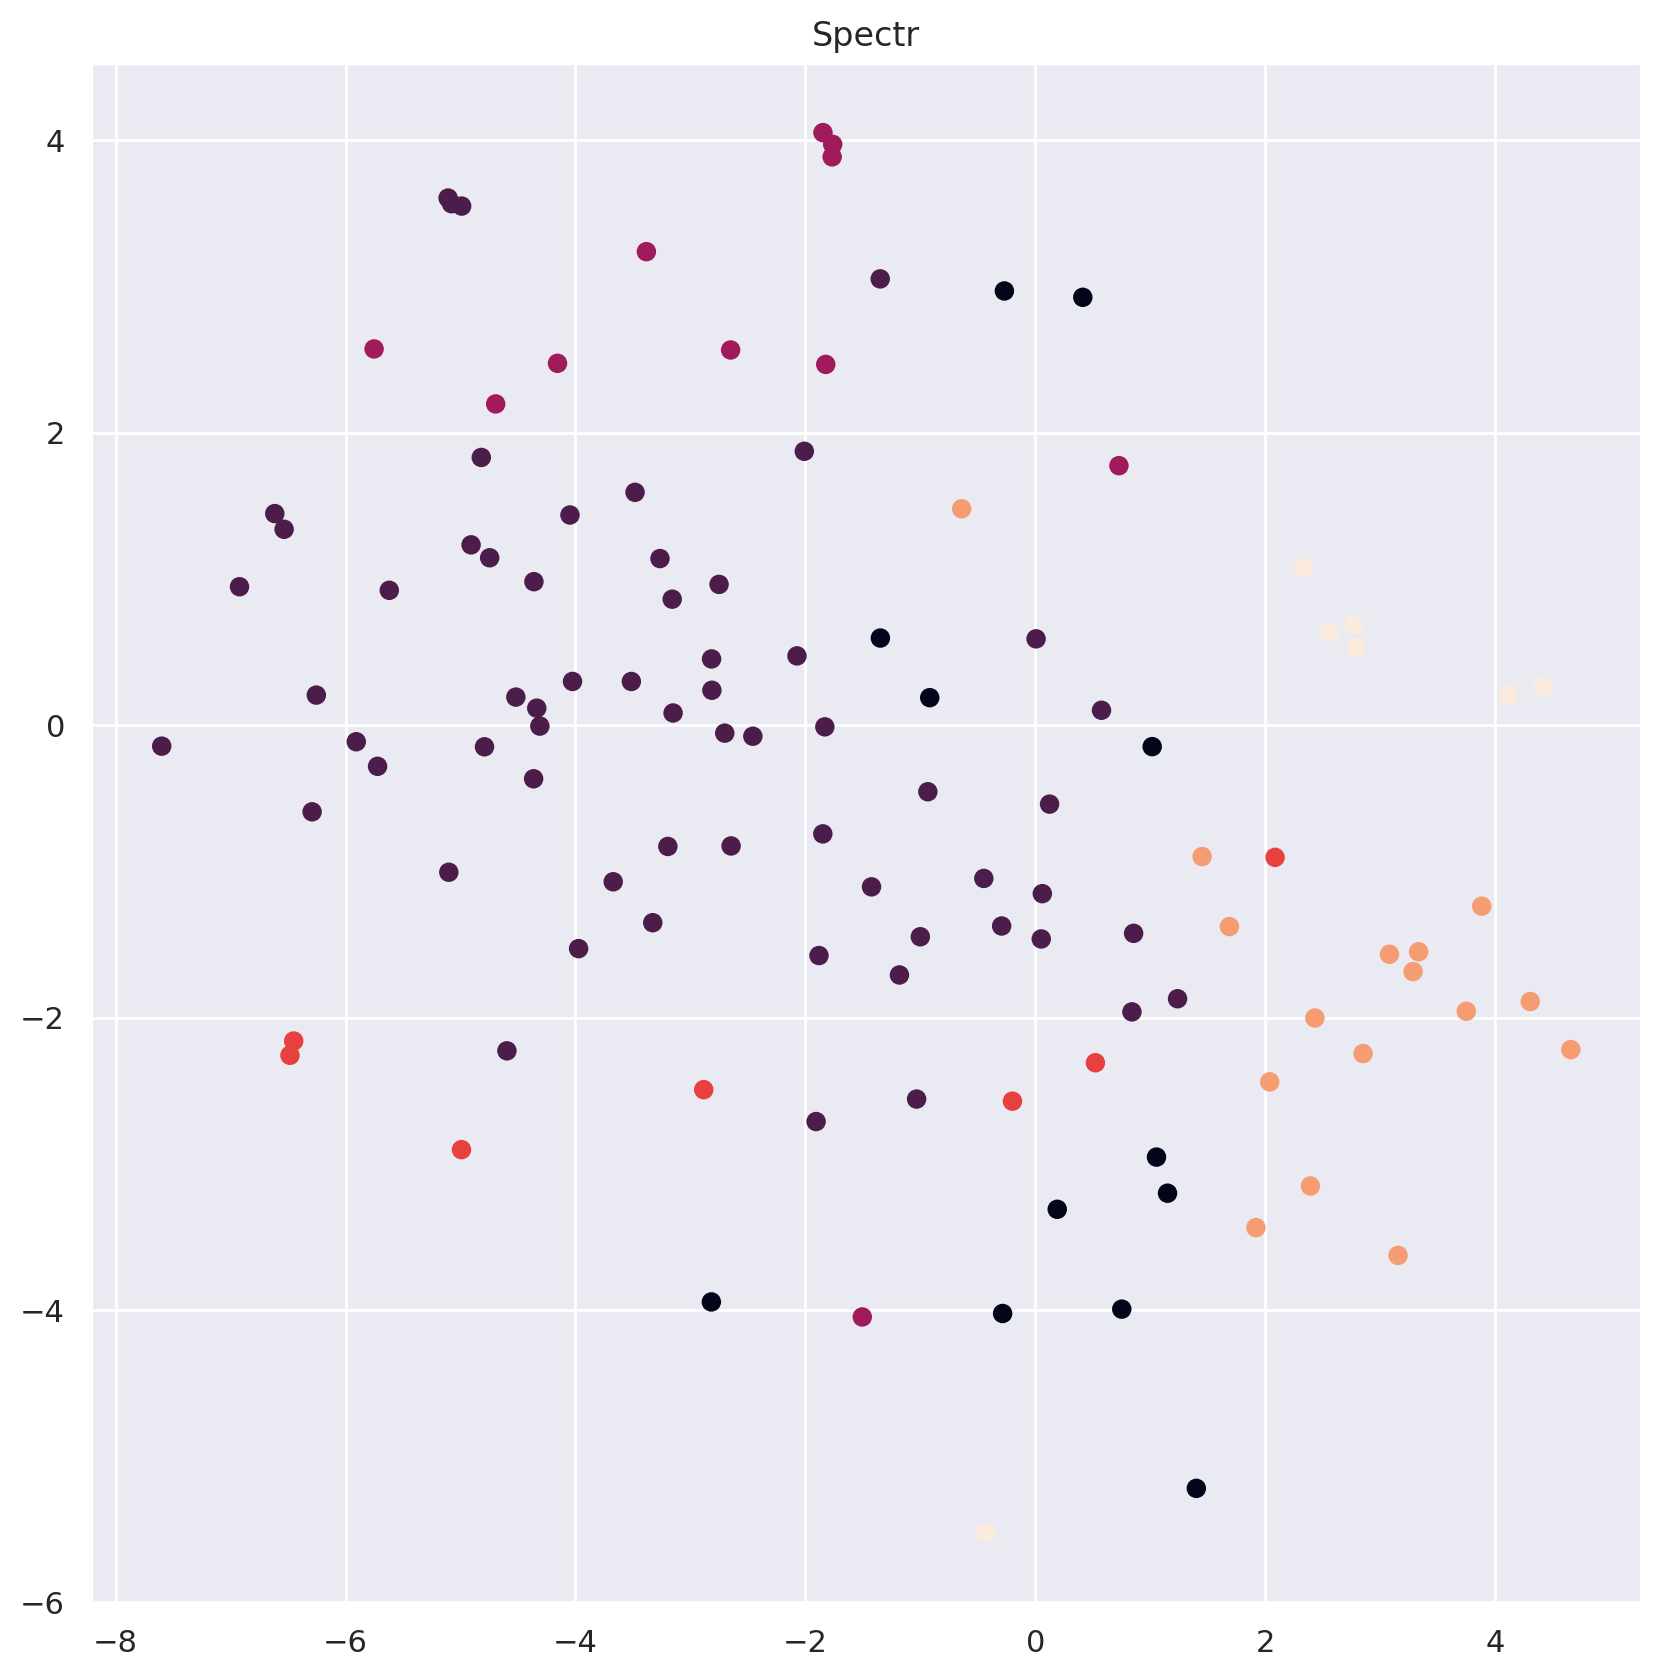

In [ ]:
sns.set(rc={'figure.figsize':(10, 10)})
plt.scatter(clusster_data['TSNE_0'], clusster_data['TSNE_1'], c=clusster_data['bert_clusters'])
plt.title('Spectr')

___